## Oxford Pets Classification: Multi-class CNN (TensorFlow/Keras)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import tensorflow_datasets as tfds
tfds.disable_progress_bar()                 # hide TFDS progress bars
import warnings

warnings.filterwarnings('ignore')
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [3]:
# Configuration
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 37
DATASET_PATH = 'oxford_pets_dataset'

# Create dataset folder
os.makedirs(DATASET_PATH, exist_ok=True)

print(f"Configuration:")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Number of Classes: {NUM_CLASSES}")

Configuration:
Image Size: 128x128
Batch Size: 32
Epochs: 10
Number of Classes: 37


In [4]:
DATASET_PATH = "dataset"

def download_oxford_pets():
    try:
        # Where TFDS stores datasets (default cache path)
        tfds_cache = Path(tfds.core.constants.DATA_DIR) / "oxford_iiit_pet"

        # Check if dataset is already cached by TFDS
        if tfds_cache.exists() and any(tfds_cache.glob("*")):
            print("Oxford Pets dataset already exists in TFDS cache.")
            (train_ds, test_ds), info = tfds.load(
                "oxford_iiit_pet",
                split=["train", "test"],
                with_info=True,
                as_supervised=True,
                download=False  # prevents re-download
            )
            return train_ds, test_ds, info

        # Otherwise, trigger download
        print("Downloading Oxford Pets dataset...")
        (train_ds, test_ds), info = tfds.load(
            "oxford_iiit_pet",
            split=["train", "test"],
            with_info=True,
            as_supervised=True,
            download=True
        )
        print("Dataset downloaded successfully!")
        return train_ds, test_ds, info

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please install tensorflow-datasets: pip install tensorflow-datasets")
        return None, None, None


# Run it
train_ds, test_ds, dataset_info = download_oxford_pets()


Oxford Pets dataset already exists in TFDS cache.


In [5]:
# Prepare the dataset
if train_ds is not None:
    # Get dataset info
    class_names = dataset_info.features['label'].names
    NUM_CLASSES = len(class_names)
    
    print(f"Total classes: {NUM_CLASSES}")
    print(f"Class names: {class_names[:10]}...")  # Show first 10 classes
    
    # Count dataset sizes
    train_size = tf.data.experimental.cardinality(train_ds).numpy()
    test_size = tf.data.experimental.cardinality(test_ds).numpy()
    
    print(f"Training samples: {train_size}")
    print(f"Test samples: {test_size}")
    
    # Split training data into train and validation
    val_size = int(0.2 * train_size)
    train_size_new = train_size - val_size
    
    # Shuffle and split
    train_ds = train_ds.shuffle(buffer_size=1000, seed=42)
    val_ds = train_ds.take(val_size)
    train_ds = train_ds.skip(val_size)
    
    print(f"Final split - Train: {train_size_new}, Val: {val_size}, Test: {test_size}")
else:
    print("Failed to load dataset. Please check your internet connection and try again.")

Total classes: 37
Class names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair']...
Training samples: 3680
Test samples: 3669
Final split - Train: 2944, Val: 736, Test: 3669


In [6]:
# Data preprocessing and augmentation
def preprocess_data(image, label):
    # Resize image to target size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment_data(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    # Random brightness
    image = tf.image.random_brightness(image, 0.2)
    # Random contrast
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

if train_ds is not None:
    # Apply preprocessing
    train_ds = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply augmentation only to training data
    train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and optimize for performance
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    print("Data preprocessing and augmentation completed!")

Data preprocessing and augmentation completed!


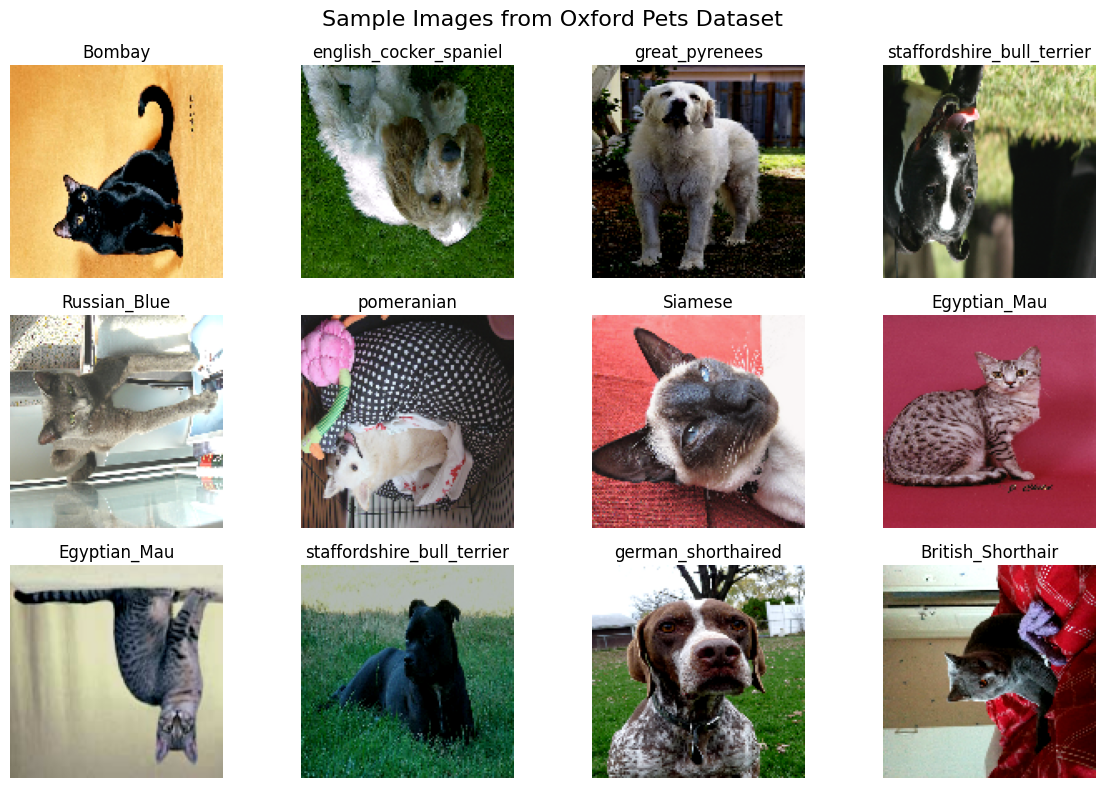


Dataset contains 37 pet breeds:
 0: Abyssinian
 1: american_bulldog
 2: american_pit_bull_terrier
 3: basset_hound
 4: beagle
 5: Bengal
 6: Birman
 7: Bombay
 8: boxer
 9: British_Shorthair
10: chihuahua
11: Egyptian_Mau
12: english_cocker_spaniel
13: english_setter
14: german_shorthaired
15: great_pyrenees
16: havanese
17: japanese_chin
18: keeshond
19: leonberger
... and 17 more breeds


In [7]:
# Visualize sample images
if train_ds is not None:
    plt.figure(figsize=(12, 8))
    
    # Take a batch of images
    for images, labels in train_ds.take(1):
        for i in range(min(12, len(images))):
            plt.subplot(3, 4, i + 1)
            plt.imshow(images[i])
            plt.title(f'{class_names[labels[i]]}')
            plt.axis('off')
    
    plt.suptitle('Sample Images from Oxford Pets Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Show class distribution
    print(f"\nDataset contains {NUM_CLASSES} pet breeds:")
    for i, name in enumerate(class_names[:20]):  # Show first 20
        print(f"{i:2d}: {name}")
    if NUM_CLASSES > 20:
        print(f"... and {NUM_CLASSES - 20} more breeds")

### Model 1: Simple CNN

In [8]:
# Build Simple CNN Model
def create_simple_cnn():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

# Create and compile the model
if train_ds is not None:
    simple_cnn = create_simple_cnn()
    
    simple_cnn.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Simple CNN Model Architecture:")
    simple_cnn.summary()

Simple CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │        18,981 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,957,797 (49.43 MB)

 Trainable params: 12,957,797 (49.43 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train Simple CNN
if train_ds is not None:
    print("Training Simple CNN...")
    
    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.0001
    )
    
    # Train the model
    history_simple = simple_cnn.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("Simple CNN training completed!")

Training Simple CNN...
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 289ms/step - accuracy: 0.0285 - loss: 3.6187 - val_accuracy: 0.0408 - val_loss: 3.6078 - learning_rate: 0.0010
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 305ms/step - accuracy: 0.0448 - loss: 3.5788 - val_accuracy: 0.0530 - val_loss: 3.4943 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 341ms/step - accuracy: 0.0526 - loss: 3.5059 - val_accuracy: 0.0639 - val_loss: 3.4405 - learning_rate: 0.0010
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step - accuracy: 0.0571 - loss: 3.4580 - val_accuracy: 0.0720 - val_loss: 3.3845 - learning_rate: 0.0010
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 319ms/step - accuracy: 0.0791 - loss: 3.4068 - val_accuracy: 0.1033 - val_loss: 3.3179 - learning_rate: 0.0010
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 303ms/step - accuracy: 0.0900 - loss: 3.3399 - val_accuracy: 0.1114 - val_loss: 3.2910 - learning_rate: 0.0010
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accu

### Model 2: Improved CNN with Batch Normalization

In [10]:
# Build Improved CNN with Batch Normalization
def create_improved_cnn():
    model = models.Sequential([
        # First Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

# Create and compile improved model
if train_ds is not None:
    improved_cnn = create_improved_cnn()
    
    improved_cnn.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
    )
    
    print("Improved CNN Model Architecture:")
    improved_cnn.summary()

Improved CNN Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37)             │        18,981 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,949 (2.07 MB)

 Trainable params: 540,965 (2.06 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [11]:
# Train Improved CNN
if train_ds is not None:
    print("Training Improved CNN...")
    
    # Train the model
    history_improved = improved_cnn.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("Improved CNN training completed!")



Training Improved CNN...
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 448ms/step - accuracy: 0.0319 - loss: 4.7698 - sparse_top_k_categorical_accuracy: 0.1688 - val_accuracy: 0.0299 - val_loss: 3.9319 - val_sparse_top_k_categorical_accuracy: 0.1454 - learning_rate: 0.0010
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step - accuracy: 0.0506 - loss: 4.4447 - sparse_top_k_categorical_accuracy: 0.1906 - val_accuracy: 0.0340 - val_loss: 4.1459 - val_sparse_top_k_categorical_accuracy: 0.1223 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy: 0.0547 - loss: 4.1758 - sparse_top_k_categorical_accuracy: 0.2143 - val_accuracy: 0.0204 - val_loss: 4.1714 - val_sparse_top_k_categorical_accuracy: 0.1359 - learning_rate: 2.0000e-04
Improved CNN training completed!


### Model 3: Transfer Learning with Pre-trained Model

In [12]:
# Create Transfer Learning Model using MobileNetV2
def create_transfer_model():
    # Load pre-trained MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom classification head
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

# Create and compile transfer learning model
if train_ds is not None:
    transfer_model = create_transfer_model()
    
    transfer_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
    )
    
    print("Transfer Learning Model Architecture:")
    transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Transfer Learning Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,725 (9.26 MB)

 Trainable params: 168,741 (659.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Train Transfer Learning Model
if train_ds is not None:
    print("Training Transfer Learning Model...")
    
    # Train the model
    history_transfer = transfer_model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("Transfer Learning model training completed!")

Training Transfer Learning Model...
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.2357 - loss: 2.8919 - sparse_top_k_categorical_accuracy: 0.5166 - val_accuracy: 0.7065 - val_loss: 1.1821 - val_sparse_top_k_categorical_accuracy: 0.9484 - learning_rate: 0.0010
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.4915 - loss: 1.7363 - sparse_top_k_categorical_accuracy: 0.8349 - val_accuracy: 0.7812 - val_loss: 0.7798 - val_sparse_top_k_categorical_accuracy: 0.9810 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.5740 - loss: 1.4141 - sparse_top_k_categorical_accuracy: 0.8828 - val_accuracy: 0.8098 - val_loss: 0.6185 - val_sparse_top_k_categorical_accuracy: 0.9851 - learning_rate: 0.0010
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.6189 - loss: 1.2454 - sparse_top_k_categorical_accuracy: 0.9154 - val_accuracy: 0.8533 - val_loss: 0.5401 - val_sparse_top_k_categorical_accuracy: 0.9878 - learni

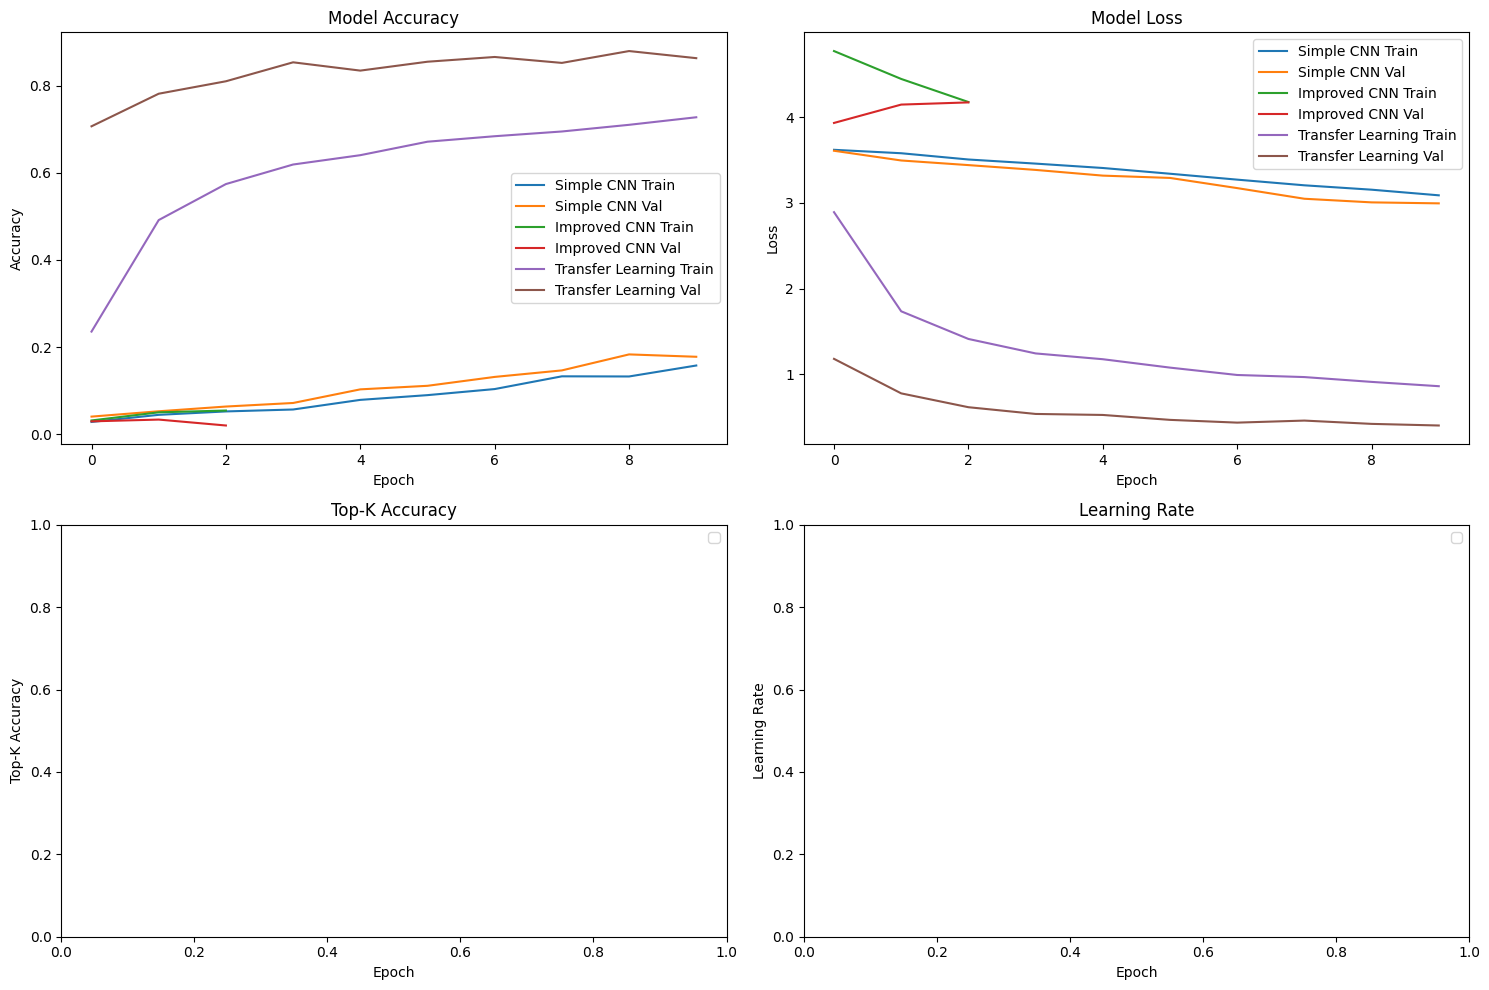

In [14]:
# Plot training history
def plot_training_history(histories, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].set_title('Model Accuracy')
    for history, name in zip(histories, model_names):
        if history is not None:
            axes[0, 0].plot(history.history['accuracy'], label=f'{name} Train')
            axes[0, 0].plot(history.history['val_accuracy'], label=f'{name} Val')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    
    # Plot training & validation loss
    axes[0, 1].set_title('Model Loss')
    for history, name in zip(histories, model_names):
        if history is not None:
            axes[0, 1].plot(history.history['loss'], label=f'{name} Train')
            axes[0, 1].plot(history.history['val_loss'], label=f'{name} Val')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    
    # Plot Top-K accuracy (if available)
    axes[1, 0].set_title('Top-K Accuracy')
    for history, name in zip(histories, model_names):
        if history is not None and 'top_k_categorical_accuracy' in history.history:
            axes[1, 0].plot(history.history['top_k_categorical_accuracy'], label=f'{name} Train')
            axes[1, 0].plot(history.history['val_top_k_categorical_accuracy'], label=f'{name} Val')
    axes[1, 0].set_ylabel('Top-K Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    
    # Learning rate (if available)
    axes[1, 1].set_title('Learning Rate')
    for history, name in zip(histories, model_names):
        if history is not None and 'lr' in history.history:
            axes[1, 1].plot(history.history['lr'], label=f'{name}')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot training histories
if 'history_simple' in locals():
    histories = []
    model_names = []
    
    if 'history_simple' in locals():
        histories.append(history_simple)
        model_names.append('Simple CNN')
    
    if 'history_improved' in locals():
        histories.append(history_improved)
        model_names.append('Improved CNN')
    
    if 'history_transfer' in locals():
        histories.append(history_transfer)
        model_names.append('Transfer Learning')
    
    plot_training_history(histories, model_names)

In [15]:
# Evaluate models on test set
def evaluate_model(model, model_name, test_dataset):
    print(f"\nEvaluating {model_name}:")
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)[:2]
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    return test_accuracy, test_loss

# Evaluate all models
if train_ds is not None:
    results = {}
    
    if 'simple_cnn' in locals():
        acc, loss = evaluate_model(simple_cnn, "Simple CNN", test_ds)
        results['Simple CNN'] = {'accuracy': acc, 'loss': loss}
    
    if 'improved_cnn' in locals():
        acc, loss = evaluate_model(improved_cnn, "Improved CNN", test_ds)
        results['Improved CNN'] = {'accuracy': acc, 'loss': loss}
    
    if 'transfer_model' in locals():
        acc, loss = evaluate_model(transfer_model, "Transfer Learning", test_ds)
        results['Transfer Learning'] = {'accuracy': acc, 'loss': loss}
    
    # Display results comparison
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    
    for model_name, metrics in results.items():
        print(f"{model_name:20s} - Accuracy: {metrics['accuracy']:.4f}, Loss: {metrics['loss']:.4f}")


Evaluating Simple CNN:
Test Accuracy: 0.1374
Test Loss: 3.1581

Evaluating Improved CNN:
Test Accuracy: 0.0253
Test Loss: 3.9342

Evaluating Transfer Learning:
Test Accuracy: 0.7781
Test Loss: 0.7115

MODEL COMPARISON RESULTS
Simple CNN           - Accuracy: 0.1374, Loss: 3.1581
Improved CNN         - Accuracy: 0.0253, Loss: 3.9342
Transfer Learning    - Accuracy: 0.7781, Loss: 0.7115


Best performing model: Transfer Learning
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


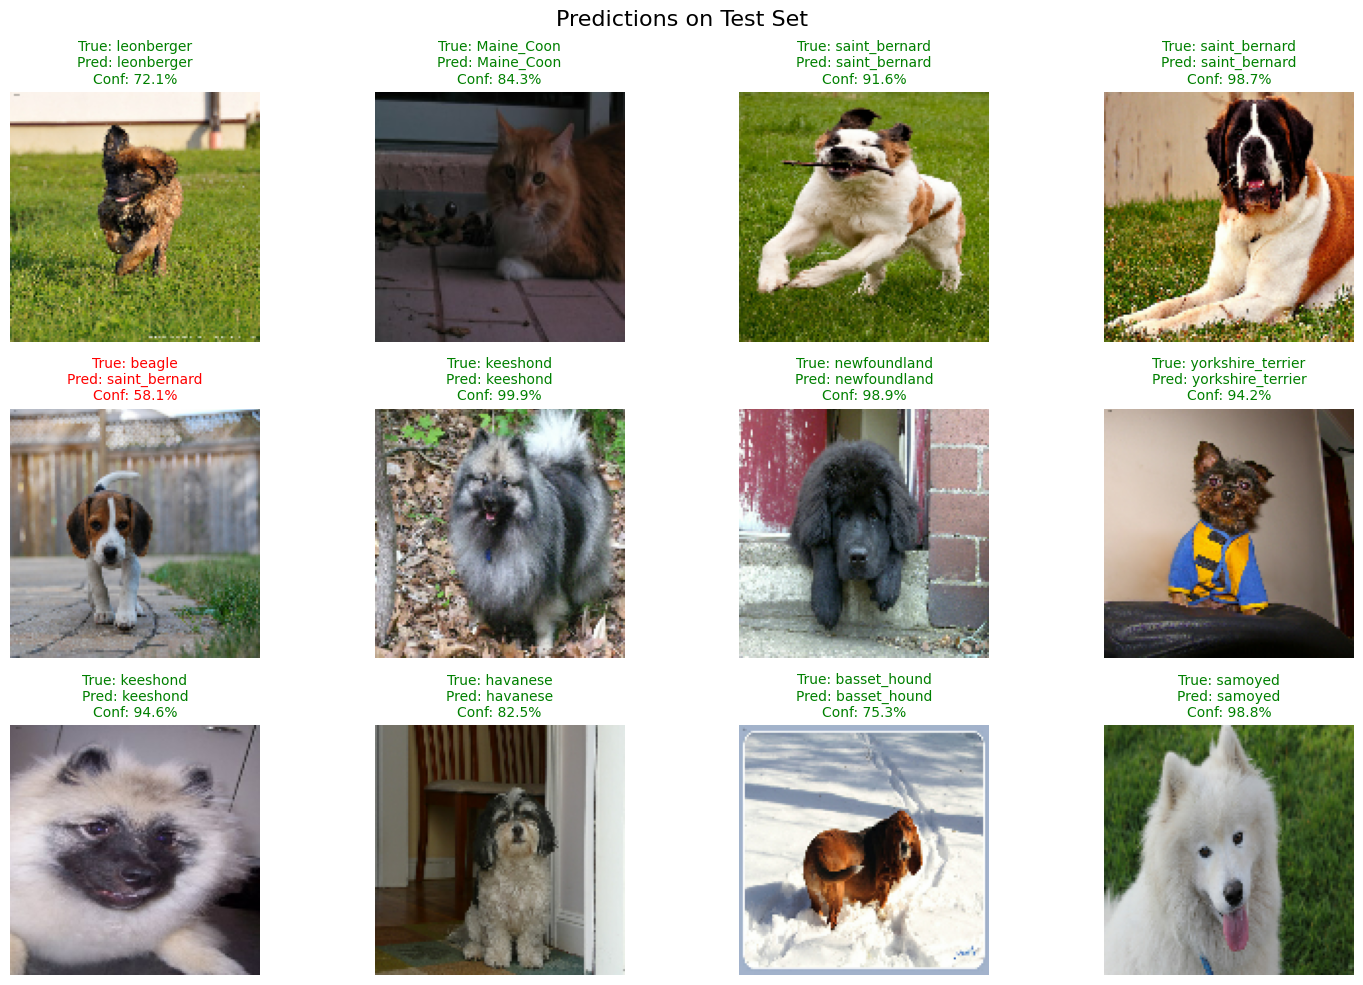

In [16]:
# Make predictions and show results
def show_predictions(model, test_dataset, class_names, num_images=12):
    # Get a batch of test images
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        
        plt.figure(figsize=(15, 10))
        
        for i in range(min(num_images, len(images))):
            plt.subplot(3, 4, i + 1)
            plt.imshow(images[i])
            
            true_class = class_names[labels[i]]
            pred_class = class_names[predicted_classes[i]]
            confidence = np.max(predictions[i]) * 100
            
            color = 'green' if labels[i] == predicted_classes[i] else 'red'
            plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%', 
                     color=color, fontsize=10)
            plt.axis('off')
        
        plt.suptitle('Predictions on Test Set', fontsize=16)
        plt.tight_layout()
        plt.show()
        break

# Show predictions for the best model
if train_ds is not None and 'results' in locals():
    # Find best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    print(f"Best performing model: {best_model_name}")
    
    # Get the best model
    if best_model_name == 'Simple CNN' and 'simple_cnn' in locals():
        best_model = simple_cnn
    elif best_model_name == 'Improved CNN' and 'improved_cnn' in locals():
        best_model = improved_cnn
    elif best_model_name == 'Transfer Learning' and 'transfer_model' in locals():
        best_model = transfer_model
    
    if 'best_model' in locals():
        show_predictions(best_model, test_ds, class_names)

In [17]:
# Generate detailed classification report
def generate_classification_report(model, test_dataset, class_names):
    # Collect all predictions and true labels
    y_true = []
    y_pred = []
    
    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes)
    
    # Generate classification report
    report = classification_report(
        y_true, y_pred, 
        target_names=class_names,
        output_dict=True
    )
    
    return report, y_true, y_pred

# Generate report for best model
if train_ds is not None and 'best_model' in locals():
    print(f"Generating detailed report for {best_model_name}...")
    
    report, y_true, y_pred = generate_classification_report(best_model, test_ds, class_names)
    
    print(f"\nOverall Metrics for {best_model_name}:")
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}")
    
    # Show top 10 best performing classes
    class_f1_scores = [(name, report[name]['f1-score']) for name in class_names if name in report]
    class_f1_scores.sort(key=lambda x: x[1], reverse=True)
    
    print("\nTop 10 Best Performing Classes:")
    for i, (class_name, f1_score) in enumerate(class_f1_scores[:10]):
        print(f"{i+1:2d}. {class_name:20s} - F1: {f1_score:.4f}")
    
    print("\nBottom 5 Performing Classes:")
    for i, (class_name, f1_score) in enumerate(class_f1_scores[-5:]):
        print(f"{len(class_f1_scores)-4+i:2d}. {class_name:20s} - F1: {f1_score:.4f}")

Generating detailed report for Transfer Learning...

Overall Metrics for Transfer Learning:
Accuracy: 0.7781
Macro Avg F1-Score: 0.7746
Weighted Avg F1-Score: 0.7751

Top 10 Best Performing Classes:
 1. pug                  - F1: 0.9158
 2. keeshond             - F1: 0.9109
 3. samoyed              - F1: 0.9029
 4. newfoundland         - F1: 0.8879
 5. scottish_terrier     - F1: 0.8788
 6. Egyptian_Mau         - F1: 0.8783
 7. yorkshire_terrier    - F1: 0.8774
 8. leonberger           - F1: 0.8767
 9. japanese_chin        - F1: 0.8725
10. great_pyrenees       - F1: 0.8556

Bottom 5 Performing Classes:
33. chihuahua            - F1: 0.6592
34. Ragdoll              - F1: 0.6269
35. British_Shorthair    - F1: 0.5921
36. staffordshire_bull_terrier - F1: 0.5488
37. american_pit_bull_terrier - F1: 0.5348


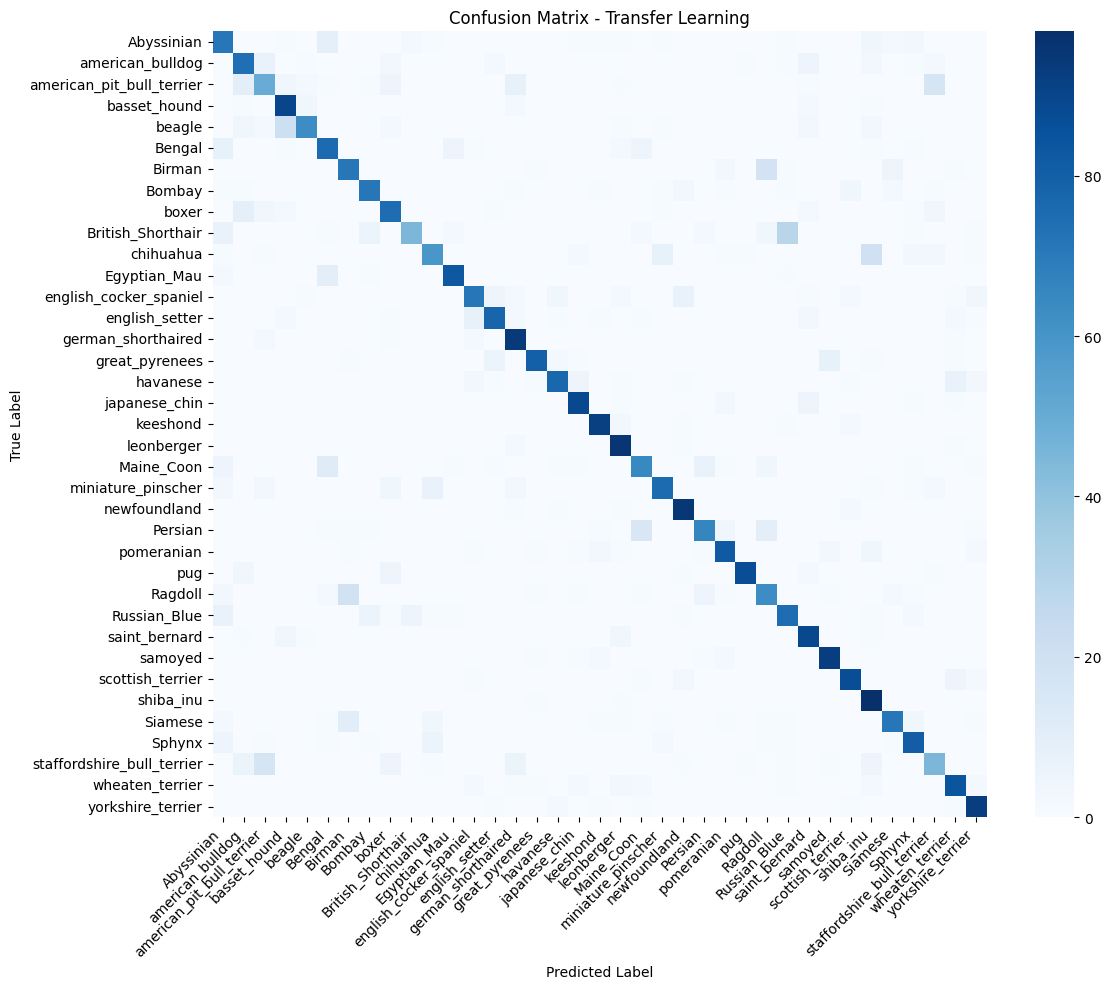

In [18]:
# Create confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for best model
if train_ds is not None and 'y_true' in locals():
    plot_confusion_matrix(y_true, y_pred, class_names, best_model_name)

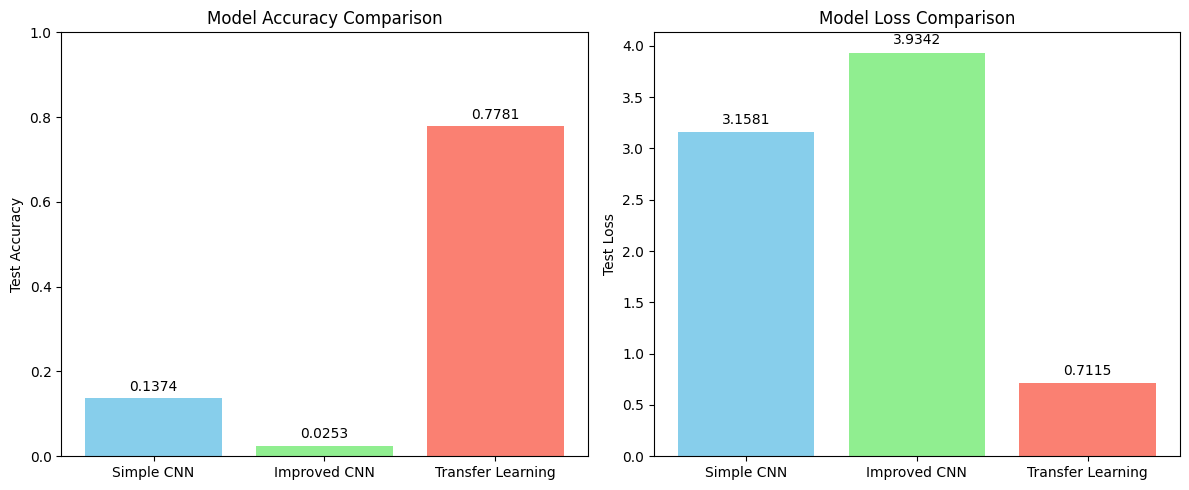


FINAL RESULTS SUMMARY
Dataset: Oxford-IIIT Pet Dataset (37 classes)
Best Model: Transfer Learning
Best Accuracy: 0.7781
Image Size: 128x128
Batch Size: 32


In [19]:
# Model comparison visualization
if train_ds is not None and 'results' in locals():
    # Create comparison chart
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    losses = [results[name]['loss'] for name in model_names]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Accuracy comparison
    bars1 = ax1.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Test Accuracy')
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.4f}', ha='center', va='bottom')
    
    # Loss comparison
    bars2 = ax2.bar(model_names, losses, color=['skyblue', 'lightgreen', 'salmon'])
    ax2.set_title('Model Loss Comparison')
    ax2.set_ylabel('Test Loss')
    
    # Add value labels on bars
    for bar, loss in zip(bars2, losses):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{loss:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("FINAL RESULTS SUMMARY")
    print("="*60)
    print(f"Dataset: Oxford-IIIT Pet Dataset ({NUM_CLASSES} classes)")
    print(f"Best Model: {best_model_name}")
    print(f"Best Accuracy: {max(accuracies):.4f}")
    print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"Batch Size: {BATCH_SIZE}")
    print("="*60)